In [1]:
# Required Libraries
%pip install -q qiskit[visualization]
%pip install -q qiskit_aer
%pip install -q qiskit_ibm_runtime
%pip install -q matplotlib

zsh:1: no matches found: qiskit[visualization]
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## BB84 Protocol

In [2]:
import math
import numpy as np
import random
import re
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

from qiskit_aer import AerSimulator

## Simulation Without the Presence of an Eavesdropper

In [3]:
# Creating registers
qr = QuantumRegister(1, name="qr")
cr = ClassicalRegister(2, name="cr")

Qubits *qr\[0\]* refers to the qubit transmitted.
Classical bit *cr\[0\]* is used by Bob to store his measurement value.
Classical bit *cr\[1\]* is used by Eve to store her measurement result of the qubit transmitted.

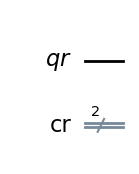

In [4]:
qc = QuantumCircuit(qr, cr, name='qc')
qc.draw('mpl')

### QBER Calculation

In [5]:
# QBER Part needs to be added here
def calculate_qber(aliceKey, bobKey, disclose = 10):
    if (len(aliceKey) != len(bobKey)):
        return -1
    key_length = len(aliceKey)
    num_disclosed = max(1, int(np.floor((key_length * disclose/100))))
    disclosed_indices = random.sample(range(key_length), num_disclosed)
    numKeyMismatches = 0
    for i in disclosed_indices:
        if (aliceKey[i] != bobKey[i]):
            numKeyMismatches += 1
    return (numKeyMismatches/num_disclosed) * 100

In [6]:
def bb84_without_eavesdropping(length = 5500, disclose_rate = 11, log = False):
    # Generating Random Bit String (Used for Raw Key) string s_A
    if (log):
        print("Generating Random Bit String for Raw Key: ")
    bitString = [random.randint(0, 1) for _ in range(length)]

    # Defining Measurement Strings for Alice and Bob:
    if (log):
        print("Defining Measurement Choices...")
    aliceMeasurementString = [random.randint(0, 1) for _ in range(length)] # string m_A of Alice
    bobMeasurementString = [random.randint(0, 1) for _ in range(length)] # string m_B of Bob

    if (log):
        print("Defining Circuits and Applying Measurements as per the string...")
    # Circuits
    circuits = []
    for i in range(length):
        circuitName = f"Singlet{i}: A{aliceMeasurementString[i]}_B{bobMeasurementString[i]}"
        circ = qc.copy()

        # Alice's Encoding of Random Bit String (s_A)
        if (bitString[i] == 1):
            circ.x(qr[0])
        if (aliceMeasurementString[i] == '1'):
            circ.h(qr[0])

        circ.barrier()

        # Bob's measurement of qubits
        if (bobMeasurementString[i] == '1'):
            circ.h(qr[0])
        
        circ.measure(qr[0], cr[0])

        circ.name = circuitName
        
        # Add the circuit to the list
        circuits.append(circ)

    if (log):
        print("Measuring Circuits using a backend simulator...")

    backend = AerSimulator()
    job = backend.run(circuits, shots = 1)
    results = job.result()

    abPatterns = [
        re.compile('.0$'),
        re.compile('.1$')
    ]

    if (log):
        print("Analysing Results...")

    bobResults = []

    for i in range(length):

        res = list(results.get_counts(circuits[i]).keys())[0] # extract the key from the dict and transform it to str; execution result of the i-th circuit

        if abPatterns[0].search(res):
            bobResults.append(0)
        if abPatterns[1].search(res):
            bobResults.append(1)

    if (log):
        print("Generating the key...")

    aliceKey = []
    bobKey = []

    # comparing the stings with measurement choices
    for i in range(length):
        if (aliceMeasurementString[i] == bobMeasurementString[i]):
            aliceKey.append(bitString[i]) 
            bobKey.append(bobResults[i])

    keyLength = len(aliceKey) # length of the secret key

    abKeyMismatches = 0 # number of mismatching bits in Alice's and Bob's keys

    for j in range(keyLength):
        if aliceKey[j] != bobKey[j]:
            abKeyMismatches += 1

    if (log):
        print("Calculating QBER...")

    error_rate = calculate_qber(aliceKey, bobKey)

    if (log):
        print("---------------------")
        print("Protocol Summary: ")
        # Keys
        print(f"Total Number of Qubits Exchanged: " + str(length))
        print(f"Alice's Key: {aliceKey}")
        print(f"Bob's key: {bobKey}")
        print(f"QBER with disclose rate {disclose_rate}%: {error_rate}")
        print('Length of the key: ' + str(keyLength))
        print('Number of mismatching bits: ' + str(abKeyMismatches) + '\n')

    return keyLength, error_rate

In [7]:
result = bb84_without_eavesdropping(log=True)

Generating Random Bit String for Raw Key: 
Defining Measurement Choices...
Defining Circuits and Applying Measurements as per the string...
Measuring Circuits using a backend simulator...
Analysing Results...
Generating the key...
Calculating QBER...
---------------------
Protocol Summary: 
Total Number of Qubits Exchanged: 5500
Alice's Key: [1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0

## Simulation of eavesdropping

### Measurement Circuits

In [8]:
measureE1 = QuantumCircuit(qr, cr, name='measureEA3')
measureE1.measure(qr[0],cr[1])

measureE2 = QuantumCircuit(qr, cr, name='measureE2')
measureE2.h(qr[0])
measureE2.measure(qr[0],cr[1])
measureE2.h(qr[0])

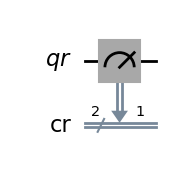

In [9]:
measureE1.draw('mpl')

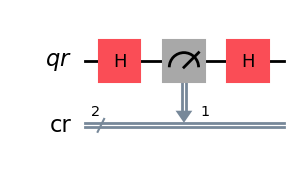

In [10]:
measureE2.draw('mpl')

In [11]:
def bb84_with_eavesdropping(length = 5500, disclose_rate = 11, qber_threshold = 0.11, log = False):
    # Generating Random Bit String (Used for Raw Key) string s_A
    if (log):
        print("Generating Random Bit String for Raw Key: ")
    bitString = [random.randint(0, 1) for _ in range(length)]

    # Defining Measurement Strings for Alice and Bob:
    if (log):
        print("Defining Measurement Choices...")
    aliceMeasurementString = [random.randint(0, 1) for _ in range(length)] # string m_A of Alice
    bobMeasurementString = [random.randint(0, 1) for _ in range(length)] # string m_B of Bob

    if (log):
        print("Defining Circuits and Applying Measurements as per the string...")
    # Circuits
    circuits = []
    attack_probability = 4 * qber_threshold
    intercepted_qubit_indices = []
    num_intercepts = 0
    for i in range(length):
        circuitName = ""
        circ = qc.copy()

        # Alice's Encoding of Random Bit String (s_A)
        if (bitString[i] == 1):
            circ.x(qr[0])
        if (aliceMeasurementString[i] == '1'):
            circ.h(qr[0])

        circ.barrier()
        eve_intercepts = np.random.rand() < attack_probability
        if (eve_intercepts):
            num_intercepts += 1
            intercepted_qubit_indices.append(i)
            if random.uniform(0, 1) <= 0.5:
                circ = circ.compose(measureE1)
            else:
                circ = circ.compose(measureE2)
            circ.barrier()
            circuitName = f"SingletABE{i}:A{aliceMeasurementString[i]}_B{bobMeasurementString[i]}_E"
        else:
            circuitName = f"SingletABE{i}:A{aliceMeasurementString[i]}_B{bobMeasurementString[i]}_NoE"
        

        # Bob's measurement of qubits
        if (bobMeasurementString[i] == '1'):
            circ.h(qr[0])
        
        circ.measure(qr[0], cr[0])

        circ.name = circuitName
        circuits.append(circ)

    if (log):
        print("Measuring Circuits using a backend simulator...")

    backend = AerSimulator()
    Eavesdropping_results = backend.run(circuits, shots = 1).result()

    ePatterns = [
        re.compile('0.$'),
        re.compile('1.$')
    ]

    abPatterns = [
        re.compile('.0$'),
        re.compile('.1$')
    ]

    if (log):
        print("Analysing Results...")

    bobResults = []
    eveResults = []

    for j in range(length):
        res = list(Eavesdropping_results.get_counts(circuits[j]).keys())[0] # extract a key from the dict and transform it to str
        # Alice and Bob
        if abPatterns[0].search(res):
            bobResults.append(0) 
        if abPatterns[1].search(res):
            bobResults.append(1)

        # Eve
        if ePatterns[0].search(res):
            eveResults.append(0) 
        if ePatterns[1].search(res): 
            eveResults.append(1)

    if (log):
        print("Generating the key...")

    aliceKey = [] # Alice's key string a
    bobKey = [] # Bob's key string a'
    eveKey = [] 

    keyIndices = [] # Indices of Qubits used for the key
    key_index_with_intercepted_qubit = [] # Indices of Alice's and Bob's Key which was formed using the qubits that was intercepted by Eve
    idx = 0
    # comparing the strings with measurement choices (b and b')
    for j in range(length):
        # if Alice and Bob measured the spin projections onto the a_2/b_1 or a_3/b_2 directions
        if (aliceMeasurementString[j] == bobMeasurementString[j]):
            keyIndices.append(j)
            if j in intercepted_qubit_indices:
                key_index_with_intercepted_qubit.append(idx)
                eveKey.append(eveResults[j])
            aliceKey.append(bitString[j]) 
            bobKey.append(bobResults[j])
            idx += 1

    keyLength = len(aliceKey) # length of the secret key

    if (log):
        print("Calculating Key Mismatches...")

    abKeyMismatches = 0 # number of mismatching bits in the keys of Alice and Bob
    eaKeyMismatches = 0 # number of mismatching bits in the keys of Eve and Alice
    ebKeyMismatches = 0 # number of mismatching bits in the keys of Eve and Bob

    for j in range(keyLength):
        if aliceKey[j] != bobKey[j]:
            abKeyMismatches += 1

    for j in range(len(key_index_with_intercepted_qubit)):
        if eveKey[j] != aliceKey[key_index_with_intercepted_qubit[j]]:
            eaKeyMismatches += 1
        if eveKey[j] != bobKey[key_index_with_intercepted_qubit[j]]:
            ebKeyMismatches += 1

    num_intercepts_used_in_key = len(key_index_with_intercepted_qubit);

    if (log):
        print("Calculating Eve's Knowledge of Alice's and Bob's Keys...")
    eaKnowledge = (num_intercepts_used_in_key - eaKeyMismatches)/num_intercepts_used_in_key # Eve's knowledge of Alice's key
    ebKnowledge = (num_intercepts_used_in_key - ebKeyMismatches)/num_intercepts_used_in_key # Eve's knowledge of Bob's key

    if (log):
        print("Calculating QBER...")
    error_rate = calculate_qber(aliceKey, bobKey)

    if (log):
        print("---------------------")
        print("Protocol Summary: ")
        print("Number of Qubits: " + str(length))
        # Keys
        print('Length of the key: ' + str(keyLength))
        print('Number of mismatching bits: ' + str(abKeyMismatches))
        print(f"QBER with disclose rate of {disclose_rate}%: {error_rate}" + '\n')

        print('Number of qubits intercepted: ' + str(num_intercepts))
        print('Number of intercepted qubits used in the key: ' + str(num_intercepts_used_in_key) + "\n")

        print('Eve Alice Key mismatches: ' + str(eaKeyMismatches))
        print('Eve Bob Key mismatches: ' + str(ebKeyMismatches) + '\n')

        print('Eve\'s knowledge of Alice\'s key: ' + str(round(eaKnowledge * 100, 2)) + ' %')
        print('Eve\'s knowledge of Bob\'s key: ' + str(round(ebKnowledge * 100, 2)) + ' %')

    return keyLength, error_rate, eaKnowledge, ebKnowledge


In [12]:
result = bb84_with_eavesdropping(length=5500, log=True)

Generating Random Bit String for Raw Key: 
Defining Measurement Choices...
Defining Circuits and Applying Measurements as per the string...
Measuring Circuits using a backend simulator...
Analysing Results...
Generating the key...
Calculating Key Mismatches...
Calculating Eve's Knowledge of Alice's and Bob's Keys...
Calculating QBER...
---------------------
Protocol Summary: 
Number of Qubits: 5500
Length of the key: 2766
Number of mismatching bits: 317
QBER with disclose rate of 11%: 9.782608695652174

Number of qubits intercepted: 2421
Number of intercepted qubits used in the key: 1175

Eve Alice Key mismatches: 290
Eve Bob Key mismatches: 291

Eve's knowledge of Alice's key: 75.32 %
Eve's knowledge of Bob's key: 75.23 %


# Graphs

### QBER Threshold v/s Eve's Knowledge of Alice's Key, Eve's Knowledge of Bob's Key

In [ ]:
number_of_qubits = 5500
values = np.linspace(0.05, 0.20, 16)
qber_threshold_values = np.round(values, 2).tolist()
eve_alice_knowledge = []
eve_bob_knowledge = []
for i in range(len(qber_threshold_values)):
    ea_outputs = []
    eb_outputs = []
    for _ in range(30):
        result = bb84_with_eavesdropping(numberOfSinglets=number_of_qubits, qber_threshold=qber_threshold_values[i])
        ea_val = result[3]
        eb_val = result[4]
        ea_outputs.append(ea_val)
        eb_outputs.append(eb_val)
    eve_alice_knowledge.append(sum(ea_outputs)/len(ea_outputs))
    eve_bob_knowledge.append(sum(eb_outputs)/len(eb_outputs))
    print(f"Circuit {i} done")

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(qber_threshold_values, eve_alice_knowledge, marker='o', label='Eve-Alice', color='blue')
plt.plot(qber_threshold_values, eve_bob_knowledge, marker='o', label='Eve-Bob', color='orange')
plt.title('QBER Threshold v/s Eve\'s Knowledge of Alice\'s and Bob\'s Key')
plt.xlabel('QBER Threshold')
plt.ylabel('Eve\'s Knowledge (Percentage)')
plt.legend()
plt.grid(True)
plt.show()

### On an average, how many times is the QBER Threshold is Violated during an Eavesdropping (30 Eavesdropping Simulations for each QBER Threshold)

In [15]:
number_of_qubits = 5500
values = np.linspace(0.07, 0.12, 6)
qber_threshold_values = np.round(values, 2).tolist()
qber_violations = []
for i in range(len(qber_threshold_values)):
    cnt = 0
    for _ in range(30):
        error_rate = bb84_with_eavesdropping(length=number_of_qubits, qber_threshold=qber_threshold_values[i])[1]
        if error_rate > (qber_threshold_values[i] * 100 + 1):
            cnt += 1
    qber_violations.append(cnt)
    print(f"Circuit {i} done")

Circuit 0 done
Circuit 1 done
Circuit 2 done
Circuit 3 done
Circuit 4 done
Circuit 5 done


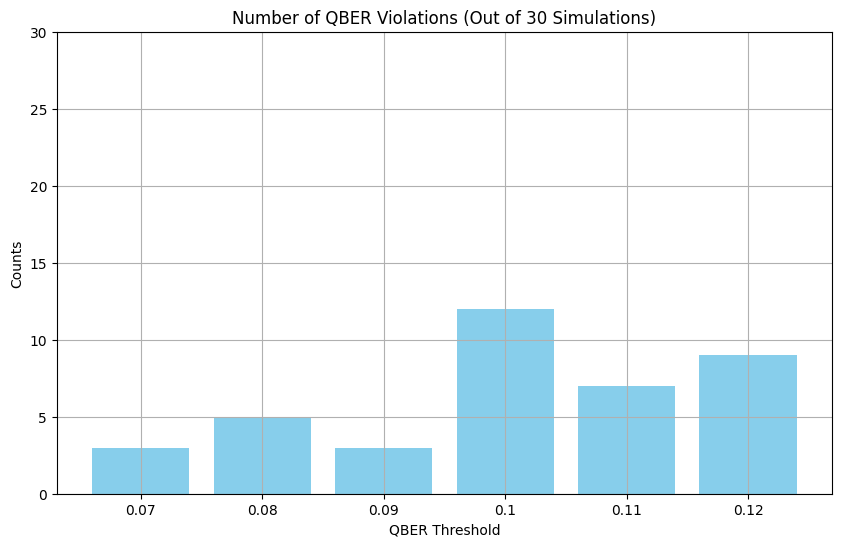

In [18]:
plt.figure(figsize=(10, 6))
qber_threshold_labels = [str(val) for val in qber_threshold_values]
plt.bar(qber_threshold_labels, qber_violations, color="skyblue")
plt.title("Number of QBER Violations (Out of 30 Simulations)")
plt.xlabel("QBER Threshold")
plt.ylabel("Counts")
plt.ylim(0, 30)
plt.grid(True)
plt.show()